### 영화 프렌즈 감성분석

영화대본을 읽어 감정을 [neutral, joy, sadness, fear, anger, surprise, disgust] 로 분류한다.


### 데이터 설명
This is the EmotionLines dataset which contains labeled emotion on every utterance in dialogues from Friends TV scripts and EmotionPush chat logs.

Data Information:
The number of dialogues in three split sets(train, dev, test) for each source are 720, 80, 200 respectively.
More details could be found in the paper "EmotionLines".

Raw Annotation:
Every utterance in both datasets containans a "annotation" string which represents the raw annotations by 5 annotators.
The emotion order of the annnotation string is [neutral, joy, sadness, fear, anger, surprise, disgust]
The detail of how we define non-neutral emotion can be found in the paper.
Examples:
- "annotation": "2003000" -> "emotion": "fear"
- "annotation": "0500000" -> "emotion": "joy"
- "annotation": "2011010" -> "emotion": "non-neutral"



https://github.com/corazzon/KaggleStruggle/blob/master/word2vec-nlp-tutorial/tutorial-part-1.ipynb

https://github.com/corazzon/KaggleStruggle/blob/master/word2vec-nlp-tutorial/tutorial-part-1.ipynb

### logistic Regression을 이용한 multiclasication

https://gist.github.com/herokyar/73cce0aa673511edf7fe


### Naive Bayes Classifier for Multinomial Models
https://towardsdatascience.com/multi-class-text-classification-model-comparison-and-selection-5eb066197568

### 케라스(Keras)

https://wikidocs.net/32105

In [1]:
from collections import defaultdict
from glob import glob
from bs4 import BeautifulSoup
from lxml import html
from konlpy.tag import Twitter

import os
import re
import time
import numpy as np
import pandas as pd
import requests
#import utils
import requests
import pandas as pd
import urllib.parse
import time
import torch
import datetime
import random
import tensorflow as tf
import numpy as np
import gensim
import json
import plotly.express as px
import cufflinks
cufflinks.go_offline(connected=True)
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\이인희\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### 데이터 읽어오기

In [2]:
dev_file = open('Data/Friends/friends_dev.json', encoding="utf-8")
dev_data = json.load(dev_file)

train_file = open('Data/Friends/friends_train.json', encoding="utf-8")
train_data = json.load(train_file)

test_file = open('Data/Friends/friends_test.json', encoding="utf-8")
test_data = json.load(test_file)

len(dev_data), len(train_data), len(test_data)

(80, 720, 200)

### 데이터 json -> DataFrame

In [3]:
df_dev = pd.DataFrame(columns=['annotation', 'emotion', 'speaker', 'utterance'])
df_train = pd.DataFrame(columns=['annotation', 'emotion', 'speaker', 'utterance'])
df_test = pd.DataFrame(columns=['annotation', 'emotion', 'speaker', 'utterance'])

for i in range(len(dev_data)):
    df_dev = pd.concat([df_dev, pd.DataFrame(dev_data[i])])

for i in range(len(train_data)):
    df_train = pd.concat([df_train, pd.DataFrame(train_data[i])])

for i in range(len(test_data)):
    df_test = pd.concat([df_test, pd.DataFrame(test_data[i])])

df_dev = df_dev.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [4]:
display(len(df_dev))
display(df_dev.head())
display(df_dev.tail())

1178

,annotation,emotion,speaker,utterance
0,0002120,non-neutral,Phoebe,"Oh my God, hes lost it. Hes totally lost it."
1,1000130,surprise,Monica,What?
2,3000200,neutral,Ross,"Or! Or, we could go to the bank, close our acc..."
3,0500000,joy,Chandler,Youre a genius!
4,0040100,sadness,Joey,"Aww, man, now we wont be bank buddies!"


,annotation,emotion,speaker,utterance
1173,2030000,sadness,Monica,No.
1174,0040010,sadness,Rachel,What? Oh my God! Im gonna miss you so much!
1175,0050000,sadness,Monica,Im gonna miss you!
1176,0050000,sadness,Rachel,I mean its the end of an era!
1177,0040010,sadness,Monica,I know!


In [5]:
pd.DataFrame(dev_data[0])

,annotation,emotion,speaker,utterance
0,0002120,non-neutral,Phoebe,"Oh my God, hes lost it. Hes totally lost it."
1,1000130,surprise,Monica,What?
2,3000200,neutral,Ross,"Or! Or, we could go to the bank, close our acc..."
3,0500000,joy,Chandler,Youre a genius!
4,0040100,sadness,Joey,"Aww, man, now we wont be bank buddies!"
5,4000010,neutral,Chandler,"Now, theres two reasons."
6,3100010,neutral,Phoebe,Hey.
7,1300010,joy,All,Hey!
8,4100000,neutral,Phoebe,"Ohh, you guys, remember that cute client I tol..."
9,0000050,surprise,Rachel,Where?!


### 데이터 정제 Data Cleaning and Text Preprocessing
기계가 텍스트를 이해할 수 있도록 텍스트를 정제해 준다.

신호와 소음을 구분한다. 아웃라이어데이터로 인한 오버피팅을 방지한다.

 - BeautifulSoup(뷰티풀숩)을 통해 HTML 태그를 제거
 - 정규표현식으로 알파벳 이외의 문자를 공백으로 치환
 - NLTK 데이터를 사용해 불용어(Stopword)를 제거
 - 어간추출(스테밍 Stemming)과 음소표기법(Lemmatizing)의 개념을 이해하고 SnowballStemmer를 통해 어간을 추출

### 텍스트 데이터 전처리 이해하기
(출처 : 트위터 한국어 형태소 분석기)

In [6]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# 랭커스터 스태머의 사용
from nltk.stem.lancaster import LancasterStemmer
lancaster_stemmer = LancasterStemmer()

from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer('english')

# Lemmatization 음소표기법
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

### Lemmatization 음소표기법
언어학에서 음소 표기법 (또는 lemmatization)은 단어의 보조 정리 또는 사전 형식에 의해 식별되는 단일 항목으로 분석 될 수 있도록 굴절 된 형태의 단어를 그룹화하는 과정이다. 예를 들어 동음이의어가 문맥에 따라 다른 의미를 갖는데

 1) *배*가 맛있다. 
 2) *배*를 타는 것이 재미있다. 
 3) 평소보다 두 *배*로 많이 먹어서 *배*가 아프다.
 
위에 있는 3개의 문장에 있는 "배"는 모두 다른 의미를 갖는다.
레마타이제이션은 이때 앞뒤 문맥을 보고 단어의 의미를 식별하는 것이다. 영어에서 meet는 meeting으로 쓰였을 때 회의를 뜻하지만 meet 일 때는 만나다는 뜻을 갖는데 그 단어가 명사로 쓰였는지 동사로 쓰였는지에 따라 적합한 의미를 갖도록 추출하는 것이다.

### 불용어 세트 만들기

In [7]:
stops = set(stopwords.words('english'))

In [8]:
stops

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [9]:
df_dev['words'] = ''
df_train['words'] = ''
df_test['words'] = ''

len(df_dev), len(df_train), len(df_test)

(1178, 10561, 2764)

### 데이터 전처리
- 정규화 normalization
- 토큰화 tokenization
- 어근화 stemming (입니다 -> 이다)
- 어구 추출 phrase extraction

In [10]:
def comment_to_words(data):
    # 1. 영어가 아닌 문자는 공백으로 변환
    data = re.sub('[^a-zA-Z]', ' ', data)
    
    # 2. 소문자로 변환
    lowerdata = data.lower()
    
    # 3. 문자열로 변환
    words = lowerdata.split()
    
    # 4. 불용어 제거
    words = [w for w in words if not w in stops]
    
    # 5. 어간추출
    stemming_words = [stemmer.stem(w) for w in words]
    
    # 7. 공백으로 구분된 문자열로 결합하여 결과를 반환
    words = ' '.join(stemming_words)
    return words

In [11]:
# 개발 데이터셋 전처리
for i in range(0, len(df_dev)):
    df_dev.loc[i, 'words'] = comment_to_words(df_dev.loc[i, 'utterance'])

# 훈련 데이터셋 전처리
for i in range(0, len(df_train)):
    df_train.loc[i, 'words'] = comment_to_words(df_train.loc[i, 'utterance'])    

# 테스트 데이터셋 전처리
for i in range(0, len(df_test)):
    df_test.loc[i, 'words'] = comment_to_words(df_test.loc[i, 'utterance'])    

### Y값 재설정
  - neutral: 0
  - surprise: 1
  - non-neutral: 2
  - joy: 3
  - sadness: 4
  - anger: 5
  - disgust: 6

In [12]:
df_train['emotion'].unique()

array(['neutral', 'surprise', 'fear', 'non-neutral', 'joy', 'sadness',
       'anger', 'disgust'], dtype=object)

In [13]:
y_info = [['neutral', 0],
          ['surprise', 1],
          ['non-neutral', 2],
          ['joy', 3],
          ['sadness', 4],
          ['anger', 5],
          ['disgust', 6]]
        

In [14]:
df_y = pd.DataFrame(y_info, columns=['emotion', 'Y'])

In [15]:
df_y

,emotion,Y
0,neutral,0
1,surprise,1
2,non-neutral,2
3,joy,3
4,sadness,4
5,anger,5
6,disgust,6


### Y열 합병

In [16]:
df_dev = pd.merge(df_dev, df_y, on=['emotion'])
df_train = pd.merge(df_train, df_y, on=['emotion'])
df_test = pd.merge(df_test, df_y, on=['emotion'])

In [17]:
df_train.head()

,annotation,emotion,speaker,utterance,words,Y
0,4100000,neutral,Chandler,also I was the point person on my companys tr...,also point person compani transit kl gr system,0
1,5000000,neutral,The Interviewer,You mustve had your hands full.,must hand full,0
2,5000000,neutral,Chandler,That I did. That I did.,,0
3,5000000,neutral,The Interviewer,So lets talk a little bit about your duties.,let talk littl bit duti,0
4,5000000,neutral,The Interviewer,"Now youll be heading a whole division, so you...",head whole divis lot duti,0


In [18]:
df_train['emotion'].value_counts().sort_values(ascending=False)[0:31][7:0:-1].iplot(kind='barh', yTitle='Numbur of Y', title='Number')

In [19]:
df_test['emotion'].value_counts().sort_values(ascending=False)[0:31][7:0:-1].iplot(kind='barh', yTitle='Numbur of Y', title='Number')

### 기초분석

In [20]:
df_dev['Y'].iplot(kind='bar')

## 1. LSTM 이용한 Multi-Class Text Classification

In [22]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics

from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras import backend as K

Using TensorFlow backend.


In [23]:
df_dev.head()

,annotation,emotion,speaker,utterance,words,Y
0,0002120,non-neutral,Phoebe,"Oh my God, hes lost it. Hes totally lost it.",oh god lost total lost,2
1,2200010,non-neutral,Phoebe,"I-Im sorry, but the moment I touch him, I jus...",sorri moment touch wanna throw old oath take n...,2
2,1000211,non-neutral,Ross,"Ah Ah Get out of here! Uh, meeting someone? ...",ah ah get uh meet someon brush marion view evolut,2
3,1021100,non-neutral,Ross,The point is I...,point,2
4,0220100,non-neutral,Ross,"It, it's too late, I'm with somebody else, I'm...",late somebodi els happi,2


In [24]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000

# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250

# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df_dev['words'].values)
word_index = tokenizer.word_index

print('Found %s unique tokens.' % len(word_index))

Found 1133 unique tokens.


In [25]:
X = tokenizer.texts_to_sequences(df_train['words'].values)
X = sequence.pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (10376, 250)


In [26]:
Y = pd.get_dummies(df_train['Y']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (10376, 7)


In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42)
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42)

print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(8300, 250) (8300, 7)
(2076, 250) (2076, 7)


In [28]:
# X_train = df_train['words'].values
# Y_train = df_train['Y'].values
# X_test = df_test['words'].values
# Y_test = df_test['Y'].values

In [29]:
X_train

array([[   0,    0,    0, ...,    8,  101,   27],
       [   0,    0,    0, ...,   27,  658,  121],
       [   0,    0,    0, ...,    0,    0,  209],
       ...,
       [   0,    0,    0, ...,    0,    0,   23],
       [   0,    0,    0, ...,    5,  224,  245],
       [   0,    0,    0, ...,   41,  726, 1095]])

In [30]:
X_train.max()

1133

In [31]:
EMBEDDING_DIM = 250
MAX_NB_WORDS = len(X_train)

In [32]:
import keras
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense, SpatialDropout1D, LSTM
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping

model = Sequential()
#model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_train.shape[0]))
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(13, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 64

MAX_NB_WORDS, EMBEDDING_DIM

(8300, 250)

In [33]:
X_train.shape, Y_train.shape, epochs, batch_size, X_train.shape[0]

((8300, 250), (8300, 7), 5, 64, 8300)

In [34]:
# # history = model.fit(X_train, 
# #                     Y_train, 
# #                     epochs=epochs, 
# #                     batch_size=batch_size,
# #                     validation_split=0.1,
# #                     callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

# history = model.fit(X_train, 
#                     Y_train,
#                    batch_size=batch_size,
#                    verbose=1,
#                    validation_split=0.1)


https://3months.tistory.com/424

In [35]:
df_dev['words'].value_counts().sort_values(ascending=False)[:10]

          69
okay      24
yeah      18
hey       16
know      14
realli     7
oh         7
sorri      6
ow         6
thank      5
Name: words, dtype: int64

In [36]:
df_dev['words'].value_counts().sort_values(ascending=False)[1:31]

okay        24
yeah        18
hey         16
know        14
realli       7
oh           7
sorri        6
ow           6
thank        5
hi           4
yes          3
good         3
said         3
hello        3
uh huh       3
ohh          3
go           3
well         3
fine         3
say          3
come         2
wow          2
ben          2
yes yes      2
would        2
got          2
sweetest     2
see          2
excus        2
juli         2
Name: words, dtype: int64

In [37]:
df_dev['words'].value_counts().sort_values(ascending=False)[1:31][31:1:-1].iplot(kind='barh', yTitle='Numbur of Script', title='Number')

In [38]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

In [39]:
tk = Tokenizer(df_train['words'], lower=True, split=" ")
tk.fit_on_texts(df_train['words'])

In [40]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier


### CountVectorizer는 이러한 작업을 하기 위한 다음과 같은 인수를 가질 수 있다.
- stop_words : 문자열 {‘english’}, 리스트 또는 None (디폴트)
   * stop words 목록.‘english’이면 영어용 스탑 워드 사용.
- analyzer : 문자열 {‘word’, ‘char’, ‘char_wb’} 또는 함수
   * 단어 n-그램, 문자 n-그램, 단어 내의 문자 n-그램
- token_pattern : string
   * 토큰 정의용 정규 표현식
- tokenizer : 함수 또는 None (디폴트)
   * 토큰 생성 함수 .
- ngram_range : (min_n, max_n) 튜플
   * n-그램 범위
- max_df : 정수 또는 [0.0, 1.0] 사이의 실수. 디폴트 1
   * 단어장에 포함되기 위한 최대 빈도
- min_df : 정수 또는 [0.0, 1.0] 사이의 실수. 디폴트 1
   * 단어장에 포함되기 위한 최소 빈도

In [41]:

# 튜토리얼과 다르게 파라메터 값을 수정
# 파라메터 값만 수정해도 캐글 스코어 차이가 많이 남
vectorizer = CountVectorizer(analyzer = 'word', 
                             tokenizer = None,
                             preprocessor = None, 
                             stop_words = None, 
                             min_df = 2, # 토큰이 나타날 최소 문서 개수
                             ngram_range=(1, 3),
                             max_features = 20000
                            )

In [42]:
from multiprocessing import Pool
import numpy as np

def _apply_df(args):
    df, func, kwargs = args
    return df.apply(func, **kwargs)

def apply_by_multiprocessing(df, func, **kwargs):
    # 키워드 항목 중 workers 파라메터를 꺼냄
    workers = kwargs.pop('workers')
    # 위에서 가져온 workers 수로 프로세스 풀을 정의
    pool = Pool(processes=workers)
    # 실행할 함수와 데이터프레임을 워커의 수 만큼 나눠 작업
    result = pool.map(_apply_df, [(d, func, kwargs)
            for d in np.array_split(df, workers)])
    pool.close()
    # 작업 결과를 합쳐서 반환
    return pd.concat(list(result))


In [43]:
%time 
#clean_train_reviews = apply_by_multiprocessing(df_train['words'], comment_to_words, workers=4)

Wall time: 0 ns


In [44]:
%time
#clean_test_reviews = apply_by_multiprocessing(df_test['words'], comment_to_words, workers=4)

Wall time: 0 ns


In [45]:
pipeline = Pipeline([
    ('vect', vectorizer),
])

In [46]:
train_data_features = pipeline.fit_transform(df_train['words'].values)
train_data_features.shape

(10376, 5523)

In [47]:
vocab = vectorizer.get_feature_names()

In [48]:
# 벡터화 된 피처를 확인해 봄
dist = np.sum(train_data_features, axis=0)

for tag, count in zip(vocab, dist):
    print(count, tag)
    
pd.DataFrame(dist, columns=vocab)

[[ 2  2 16 ...  2  3  4]] aaron


,aaron,abandon,abl,abott,absolut,absolut sure,accent,accept,accid,account,...,yike,yo,york,york citi,young,younger,yuh,yuh huh,zelner,zoo
0,2,2,16,2,20,2,2,5,6,5,...,2,2,6,2,5,2,2,2,3,4


### 랜덤포레스트 모델로 학습

In [49]:
# 랜덤포레스트 분류기를 사용
forest = RandomForestClassifier(n_estimators = 50, n_jobs = -1, random_state=0)
forest

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [50]:
data = pd.DataFrame(train_data_features.toarray(), columns=vocab)

In [51]:
%%time
forest.fit(data.values, df_train['Y'])

Wall time: 12.3 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [52]:
%time 
score = np.mean(cross_val_score(forest,
                                train_data_features,
                                df_train['Y'],
                                cv=10))
score

Wall time: 0 ns


0.46654907505745136

### 랜덤포레스트 TEST

In [53]:
test_data_features = pipeline.transform(df_test['words'].values)
test_data_features = test_data_features.toarray()

In [54]:
%time 
score = np.mean(cross_val_score(forest,
                                test_data_features,
                                df_test['Y'],
                                cv=10))
score

Wall time: 0 ns


0.44717873419357845

### 단어 벡터화

In [55]:
vectorizer = CountVectorizer(analyzer = 'word', 
                             tokenizer = nltk.word_tokenize,
                             preprocessor = None, 
                             stop_words = None, 
                             min_df = 2, # 토큰이 나타날 최소 문서 개수
                             ngram_range=(1, 4),
                             max_features = 10000
                            )

In [56]:
pipeline = Pipeline([
    ('vect', vectorizer),
])

In [57]:
# train_data_features = pipeline.fit_transform(df_train['words'].values)
# vectorizer._validate_vocabulary()
# vocab = vectorizer.get_feature_names()



In [58]:
vectorizer = CountVectorizer(analyzer = 'word', 
                             tokenizer = None,
                             preprocessor = None, 
                             stop_words = stops, 
                             min_df = 4, # 토큰이 나타날 최소 문서 개수
                             ngram_range=(1, 4),
                             max_features = 10000
                            )

pipeline = Pipeline([
    ('vect', vectorizer),
])

train_data_features = pipeline.fit_transform(df_train['words'].values)
vectorizer._validate_vocabulary()
vocab = vectorizer.get_feature_names()

# 벡터화 된 피처를 확인해 봄
dist = np.sum(train_data_features, axis=0)

for tag, count in zip(vocab, dist):
    print(count, tag)
    
# 랜덤포레스트 분류기를 사용
forest = RandomForestClassifier(n_estimators = 50, n_jobs = -1, random_state=0)
data = pd.DataFrame(train_data_features.toarray(), columns=vocab)

# 데이터 학습
forest.fit(data.values, df_train['Y'])

score = np.mean(cross_val_score(forest,
                                train_data_features,
                                df_train['Y'],
                                cv=10))

# 정확도 출력 
score



[[16 20  5 ...  6  5  4]] abl


0.4660757308444044

In [59]:
# 벡터화 된 피처를 확인해 봄
dist = np.sum(train_data_features, axis=0)

for tag, count in zip(vocab, dist):
    print(count, tag)
    
pd.DataFrame(dist, columns=vocab)


[[16 20  5 ...  6  5  4]] abl


,abl,absolut,accept,accid,account,across,act,actor,actual,actual think,...,yep,yes,yes pleas,yes thank,yes yes,yesterday,yet,york,young,zoo
0,16,20,5,6,5,7,5,13,90,4,...,18,167,4,6,16,9,39,6,5,4


In [60]:
# 랜덤포레스트 분류기를 사용
forest = RandomForestClassifier(n_estimators = 50, n_jobs = -1, random_state=0)
data = pd.DataFrame(train_data_features.toarray(), columns=vocab)

forest.fit(data.values, df_train['Y'])

score = np.mean(cross_val_score(forest,
                                train_data_features,
                                df_train['Y'],
                                cv=10))
score

0.4660757308444044

### 테스트

In [61]:
test_data_features = pipeline.transform(df_test['words'].values)
test_data_features = test_data_features.toarray()

In [62]:
score = np.mean(cross_val_score(forest,
                                test_data_features,
                                df_test['Y'],
                                cv=10))
score

0.4384427759252786

### 테스트

In [65]:
train_data_features = pipeline.fit_transform(df_train['words'].values)

In [66]:
# 테스트 데이터를 벡터화 함
%time 
test_data_features = pipeline.transform(df_test['words'].values)
test_data_features = test_data_features.toarray()

Wall time: 0 ns


In [67]:
train_data_features[:10]

<10x1858 sparse matrix of type '<class 'numpy.int64'>'
	with 32 stored elements in Compressed Sparse Row format>

In [68]:
train_data_features.shape

(10376, 1858)

In [69]:
test_data_features[:10]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [70]:
test_data_features.shape

(2732, 1858)

In [71]:
testdata = pd.DataFrame(test_data_features, columns=vocab)

In [72]:
test_data_features

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [73]:
# score = np.mean(cross_val_score(\
#     forest, train_data_features, \
#     df_train['Y'], cv=10, scoring='roc_auc'))
# score

In [74]:
#train_data_features = pipeline.fit_transform(df_train['words'].values)

In [75]:
# 테스트 데이터를 넣고 예측한다.
result = forest.predict(test_data_features)


## TF IDF 이용
### Multi-Class Classification with Logistic Regression


In [76]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model.logistic import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection  import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline

In [77]:
pipeline = Pipeline([
    ('vect', TfidfVectorizer(stop_words='english')),
    ('clf', LogisticRegression())
])

parameters = {
    'vect__max_df': (0.25, 0.5),
    'vect__ngram_range': ((1, 1), (1, 2)),
    'vect__use_idf': (True, False),
    'clf__C': (0.1, 1, 10),
}

In [78]:
X_train,  _, y_train, _ = train_test_split(df_train['words'], df_train['Y'], train_size=0.9999)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.



In [79]:
_, X_test, _, y_test = train_test_split(df_test['words'], df_test['Y'], train_size=0.00001)
len(X_train), len(X_test), len(y_train), len(y_test)

(10374, 2732, 10374, 2732)

In [80]:
grid_search = GridSearchCV(pipeline, parameters, n_jobs=3, verbose=1, scoring='accuracy')
grid_search.fit(X_train, y_train)
print('best score: %0.3f' % grid_search.best_score_)
print('best parameters set:')
best_parameters = grid_search.best_estimator_.get_params()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning:

You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.



Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    3.9s
[Parallel(n_jobs=3)]: Done  72 out of  72 | elapsed:    6.4s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.



best score: 0.496
best parameters set:


In [81]:
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print('\t %s: %r' % (param_name, best_parameters[param_name]))

	 clf__C: 1
	 vect__max_df: 0.25
	 vect__ngram_range: (1, 2)
	 vect__use_idf: False


In [82]:
predictions = grid_search.predict(X_test)
print('Accuracy:', accuracy_score(y_test, predictions))
print('Confusion Matrix:', confusion_matrix(y_test, predictions))
print('*************************************************************')
print('Classification Report:')
print(classification_report(y_test, predictions,target_names=df_y['emotion']))

Accuracy: 0.5062225475841874
Confusion Matrix: [[1186   10   60   27    3    1    0]
 [ 183   70   26    5    2    0    0]
 [ 432   28   64   14    3    0    0]
 [ 229   11   12   52    0    0    0]
 [  63    2   11    1    8    0    0]
 [ 125    5   27    2    0    1    1]
 [  51    2   10    2    1    0    2]]
*************************************************************
Classification Report:
              precision    recall  f1-score   support

     neutral       0.52      0.92      0.67      1287
    surprise       0.55      0.24      0.34       286
 non-neutral       0.30      0.12      0.17       541
         joy       0.50      0.17      0.26       304
     sadness       0.47      0.09      0.16        85
       anger       0.50      0.01      0.01       161
     disgust       0.67      0.03      0.06        68

   micro avg       0.51      0.51      0.51      2732
   macro avg       0.50      0.23      0.24      2732
weighted avg       0.48      0.51      0.42      2732



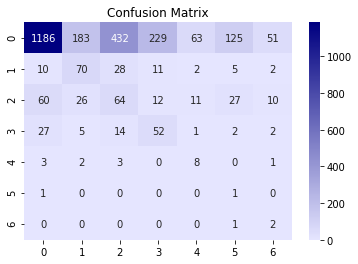

In [90]:
from sklearn.metrics import confusion_matrix
from matplotlib import  pylab as plt
import seaborn as sns

cm = confusion_matrix(predictions, y_test)
sns.heatmap(cm, cmap=sns.light_palette(
    "navy", as_cmap=True), annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.show()

### Naive Bayes Classifier for Multinomial Models

https://towardsdatascience.com/multi-class-text-classification-model-comparison-and-selection-5eb066197568

In [84]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])

In [85]:
nb.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...inear_tf=False, use_idf=True)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [86]:
print('accuracy %s' % accuracy_score(nb.predict(X_train), y_train))

accuracy 0.5300751879699248


In [87]:
y_pred = nb.predict(X_test)

In [88]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=df_y['emotion']))

accuracy 0.4908491947291362
              precision    recall  f1-score   support

     neutral       0.49      0.99      0.66      1287
    surprise       0.72      0.12      0.20       286
 non-neutral       0.30      0.05      0.08       541
         joy       0.58      0.04      0.07       304
     sadness       0.00      0.00      0.00        85
       anger       0.00      0.00      0.00       161
     disgust       0.00      0.00      0.00        68

   micro avg       0.49      0.49      0.49      2732
   macro avg       0.30      0.17      0.14      2732
weighted avg       0.43      0.49      0.35      2732



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



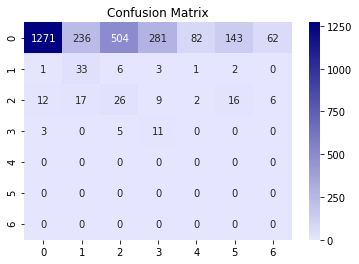

In [89]:
from sklearn.metrics import confusion_matrix
from matplotlib import  pylab as plt
import seaborn as sns

cm = confusion_matrix(y_pred, y_test)
sns.heatmap(cm, cmap=sns.light_palette(
    "navy", as_cmap=True), annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.show()

### Linear Support Vector Machine

In [100]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=0.001, random_state=0, max_iter=5, tol=None)),
               ])

sgd.fit(X_train, y_train)
print('accuracy %s' % accuracy_score(sgd.predict(X_train), y_train))

y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_pred, y_test))

accuracy 0.5295932138037401
accuracy 0.49670571010248904
              precision    recall  f1-score   support

           0       0.92      0.51      0.66      2298
           1       0.28      0.49      0.35       162
           2       0.05      0.25      0.09       118
           3       0.16      0.45      0.23       106
           4       0.12      0.37      0.18        27
           5       0.03      0.45      0.06        11
           6       0.04      0.30      0.08        10

   micro avg       0.50      0.50      0.50      2732
   macro avg       0.23      0.40      0.24      2732
weighted avg       0.80      0.50      0.59      2732



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning:

max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.



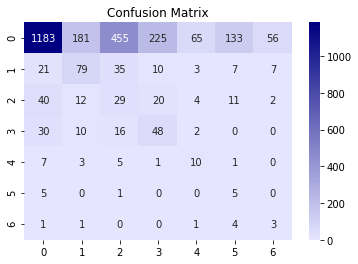

In [101]:
from sklearn.metrics import confusion_matrix
from matplotlib import  pylab as plt
import seaborn as sns

cm = confusion_matrix(y_pred, y_test)
sns.heatmap(cm, cmap=sns.light_palette(
    "navy", as_cmap=True), annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.show()